# Data Cleaning

## Retrieving reviews

In [1]:
import os
import pandas as pd
import nltk
import numpy as np
import pandas as pd
import regex
import string
import unicodedata
import html
from html.parser import HTMLParser

from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.sentiment.util import  mark_negation
from nltk.tokenize import TweetTokenizer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report as clsr
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split

## Cleaning and Tokenizing

We need to build a preprocessor first tokenize the reviews.

In [2]:
class Preprocessor(BaseEstimator, TransformerMixin):


    def __init__(self, lower=True, strip=True, remove_punct=True, remove_diacritics=True, unicode_form='NFC', remove_stop=False, stem_tokens=False, lemmatize_tokens=True, language='english'):
        
        self.lower      = lower
        self.strip      = strip
        self.remove_punct = remove_punct
        self.remove_diacritics = remove_diacritics
        self.set_unicode_form(unicode_form)
     
        self.remove_stop = remove_stop
        self.stem_tokens = stem_tokens
        self.lemmatize_tokens = lemmatize_tokens    

        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.punct      = set(string.punctuation)

        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = nltk.stem.SnowballStemmer(language) 
        self.tokenizer = TweetTokenizer()

 
    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]


    def fit(self, X, y=None):
        return self

 
    def set_stopwords(self, stopwords):
        self.stopwords  = stopwords or set(nltk.corpus.stopwords.words('english'))


    def set_punct(self, punct):
        self.punct      = punct or set(string.punctuation)


    def set_unicode_form(self, unicode_form):
        self.unicode_form = unicode_form.strip().upper()
        if not self.unicode_form in ['NFC','NFD','NFKC','NFKD']:
            self.unicode_form = 'NFC'


    def show_settings(self):
        print("lower: ",self.lower)
        print("strip: ",self.strip)
        print("remove_punct: ",self.remove_punct)
        print("remove_diacritics: ",self.remove_diacritics)
        print("unicode_form: ",self.unicode_form)
        print("remove_stop: ",self.remove_stop)
        print("stem_tokens: ",self.stem_tokens)
        print("lemmatize_tokens",self.lemmatize_tokens)       
        print("lemmatizer: ",type(self.lemmatizer).__name__)
        print("stemmer: ",type(self.stemmer).__name__) 
        print("punctuation: ",self.punct)
        print("stopwords: ",self.stopwords)


    # convert nltk pos-tag to wordnet pos-tag
    # for use by the wordnet lemmatizer
    @staticmethod
    def get_wordnet_tag(nltk_tag):
        if nltk_tag.startswith('N'):
            return wn.NOUN
        elif nltk_tag.startswith('V'):
            return wn.VERB
        elif nltk_tag.startswith('J'):
            return wn.ADJ
        elif nltk_tag.startswith('R'):
            return wn.ADV
        else:          
            return None

    # determine whether a string is comprised of all punctuation-like characters
    def is_punct(self, text):
        if text in self.punctuation:
            return True
        if regex.match(r"[\p{P}\p{Mn}\p{Sk}]+", text):
            return True
        return False


    # normalize token strings
    def normalize_string(self, token):

        token = html.unescape(token)
        token = token.lower() if self.lower else token
        token = token.strip(' _*')  if self.strip else token

        if self.remove_diacritics:
            token = regex.sub("\p{Mn}",'',unicodedata.normalize('NFD',token)) 

        #not is in the stopword list, but n't isn'
        if token == "n't" and self.stopwords:
            token = "not"
      
        return unicodedata.normalize(self.unicode_form,token)

    # determine whether a string is comprised completely
    # of things that seem like punctuation
    def is_punct(self, text):
        if text in string.punctuation:
            return True
        if regex.match(r"^[\p{P}\p{Mn}\p{Sk}]+$", text):
            return True
        return False

    # tokenize the document with optional normalization
    def tokenize(self, document, all_fields=False):
        tokens = []
        for sent in sent_tokenize(document):
            cleaner_sent = html.unescape(sent)
            for token in nltk.pos_tag(self.tokenizer.tokenize(cleaner_sent)):
                stem = ''
                token_text = self.normalize_string(token[0])
                token_pos = token[1]
                if self.remove_punct and self.is_punct(token_text):
                #if remove_punct and token_text in string.punctuation:
                    continue
                if self.remove_stop and token_text in self.stopwords:
                    continue
                if self.stem_tokens or all_fields:
                    stem = self.stemmer.stem(token_text)
                if self.lemmatize_tokens or all_fields:
                    wordnet_tag = self.get_wordnet_tag(token_pos)
                    if wordnet_tag is not None:
                        lemma = self.lemmatizer.lemmatize(token_text,wordnet_tag)
                    else:
                        lemma = token_text
                if all_fields:
                    tokens.append({'token': token_text, 'stem': stem, 'lemma': lemma})
                elif self.stem_tokens:
                    tokens.append(stem)
                elif self.lemmatize_tokens:
                    tokens.append(lemma)
                else:
                    tokens.append(token_text)     
        return tokens

# Exploratory Data analysis

## Test Data Set

In [3]:
mydf=pd.read_csv("./Hotel_reviews.csv")

In [4]:
#save test data set to csv file
#train,test=train_test_split(mydf,test_size=0.2,random_state=1)
#test.to_csv('./hotel_test.csv',index=False)

In [5]:
y_labels=mydf['Authenticity']
X_data=mydf.drop('Authenticity', axis=1)
X_data_train,X_data_test,y_labels_train,y_labels_test=train_test_split(X_data,y_labels,test_size=0.2,random_state=1)

In [6]:
X_data_test=X_data_test.reset_index(drop=True)
X_data_test

,Resource,Hotel,Review,Stance
0,MTurk,sofitel,"['best', 'hotel', 'excellent', 'location', 'st...",positive
1,Web,talbott,"['find', 'hotel', 'small', 'luxury', 'hotel', ...",negative
2,TripAdvisor,james,"['husband', 'want', 'spend', 'weekend', 'chica...",positive
3,Web,hardrock,"['check-in', 'great', 'get', 'room', 'carpet',...",negative
4,Web,knickerbocker,"['book', 'hotel', 'read', 'review', 'concern',...",negative
...,...,...,...,...
315,MTurk,ambassador,"['ambassador', 'east', 'hotel', 'terrible', 'p...",negative
316,MTurk,hardrock,"['first', 'book', 'reservation', 'hotel', 'hon...",positive
317,Web,amalfi,"['often', 'visit', 'chicago', 'first', 'stay',...",negative
318,Web,james,"['return', 'james', 'hotel', 'stay', 'park', '...",negative


In [7]:
y_labels_test=y_labels_test.reset_index(drop=True)
y_labels_test

0      deceptive
1       truthful
2       truthful
3       truthful
4       truthful
         ...    
315    deceptive
316    deceptive
317     truthful
318     truthful
319    deceptive
Name: Authenticity, Length: 320, dtype: object

In [8]:
vocabulary = {}
hotel_vocabularies = {}
#my_preprocessor = Preprocessor(remove_punct=True, remove_stop=False, remove_diacritics=True, lemmatize_tokens=True)
my_preprocessor = Preprocessor(remove_punct=True, remove_stop=True, lemmatize_tokens=True)

# Now we create a method for doing token analysis and generating the counts we need
def get_token_analysis(review_text, hotel=None):
    tokens = my_preprocessor.tokenize(review_text)
    for token in tokens:
            if token in vocabulary:
                vocabulary[token] += 1
            else:
                vocabulary[token] = 1
            if hotel:
                if hotel in hotel_vocabularies:
                    hotel_dict = hotel_vocabularies[hotel]
                    if token in hotel_dict:
                        hotel_dict[token] += 1
                    else:
                        hotel_dict[token] = 1
                    hotel_vocabularies[hotel] = hotel_dict
                else:
                    hotel_vocabularies[hotel] = {token: 1}
            
    return tokens

In [9]:
num_reviews = 0
total_tokens = 0
total_review_length_in_chars = 0
review_lengths_in_tokens = []


# iterate over the rows in your dataframe, keeping track of various counts
for row in X_data_test.itertuples():
    num_reviews += 1
    total_review_length_in_chars += len(row.Review)
    tokens = get_token_analysis(row.Review, row.Hotel)
    review_lengths_in_tokens.append(len(tokens))
    total_tokens += len(tokens)


# reverse frequency sort the vocabulary
sorted_vocabulary = sorted(vocabulary.items(), key=lambda x:x[1], reverse=True)

# reverse frequency sort all of the hotel-specific dictionaries
for current_hotel in hotel_vocabularies.keys():
    cur_dict = hotel_vocabularies[current_hotel]
    sorted_dict = sorted(cur_dict.items(), key=lambda x:x[1], reverse=True)
    hotel_vocabularies[current_hotel] = sorted_dict

# add the token count for each review to the dataframe 
X_data_test['num_tokens'] = review_lengths_in_tokens
print("headers: ",list(X_data_test.columns))

headers:  ['Resource', 'Hotel', 'Review', 'Stance', 'num_tokens']


### The total number of reviews

In [10]:
num_reviews= len(X_data_test)
print('The total number of reviews: ',num_reviews)

The total number of reviews:  320


### The total number of distinct words (vocabulary)

In [11]:
print("The total tokens:",X_data_test['num_tokens'].sum())

The total tokens: 23373


In [12]:
print("The total number of distinct words:", len(vocabulary))

The total number of distinct words: 3497


In [13]:
import matplotlib.pyplot as mpltimport 
import seaborn as sns
import matplotlib.pyplot as plt
from urllib import request

### The label and number of hotels in the data set

In [14]:
print("Hotels and Counts: ",X_data_test['Hotel'].value_counts().to_dict())

Hotels and Counts:  {'omni': 26, 'fairmont': 22, 'affinia': 22, 'sheraton': 21, 'sofitel': 21, 'knickerbocker': 20, 'conrad': 18, 'swissotel': 16, 'hardrock': 15, 'homewood': 15, 'ambassador': 14, 'palmer': 14, 'monaco': 14, 'hyatt': 13, 'james': 13, 'allegro': 13, 'hilton': 12, 'intercontinental': 12, 'talbott': 12, 'amalfi': 7}


In [15]:
numbyhotel=(X_data_test['Hotel'].value_counts()).to_frame()
numbyhotel['Label'] = list(numbyhotel.index)
print("Number of Hotel by Label:")
print(numbyhotel.to_string(index=False))

Number of Hotel by Label:
 Hotel             Label
    26              omni
    22          fairmont
    22           affinia
    21          sheraton
    21           sofitel
    20     knickerbocker
    18            conrad
    16         swissotel
    15          hardrock
    15          homewood
    14        ambassador
    14            palmer
    14            monaco
    13             hyatt
    13             james
    13           allegro
    12            hilton
    12  intercontinental
    12           talbott
     7            amalfi


Text(0.5, 1.0, 'Label and Number of Hotel')

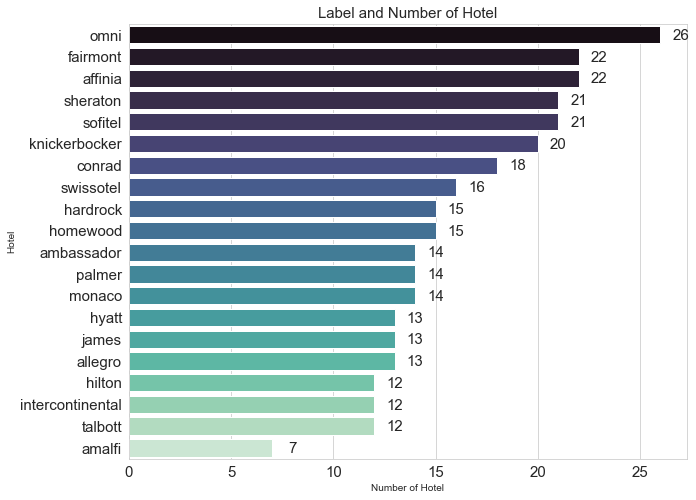

In [16]:
sns.set_style("whitegrid")
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)

g = sns.barplot(
    data=numbyhotel,
    y="Label", x="Hotel",
    ax=ax,palette="mako"
)
for p in g.patches:
    width = p.get_width()
    plt.text(1+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center',size=15)
g.set(xlabel='Number of Hotel', ylabel='Hotel')
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Label and Number of Hotel", size=15)

There are 20 hotels in the test data set. The distribution of each hotel is shown in the above bar chart. Omni is the most frequent hotel and Amalfi is the least frequent hotel in the test data set.

### The average number of words in each review per hotel

In [17]:
print("The average words in each review",X_data_test['num_tokens'].mean())

The average words in each review 73.040625


In [18]:
print("The average words in each review per hotel: ")
results = X_data_test['num_tokens'].groupby(X_data_test['Hotel']).mean()
avg_words_review=(results).to_frame()
avg_words_review['Label'] = list(avg_words_review.index)
print(avg_words_review.to_string(index=False))

The average words in each review per hotel: 
 num_tokens             Label
  74.136364           affinia
  87.307692           allegro
  90.285714            amalfi
  59.214286        ambassador
  89.222222            conrad
  79.454545          fairmont
  86.066667          hardrock
  58.583333            hilton
  65.000000          homewood
  71.153846             hyatt
  57.583333  intercontinental
  85.230769             james
  65.350000     knickerbocker
  76.642857            monaco
  73.230769              omni
  64.500000            palmer
  67.047619          sheraton
  72.333333           sofitel
  65.687500         swissotel
  77.833333           talbott


Text(0.5, 1.0, 'Average Number of Words in Each Review by Hotel')

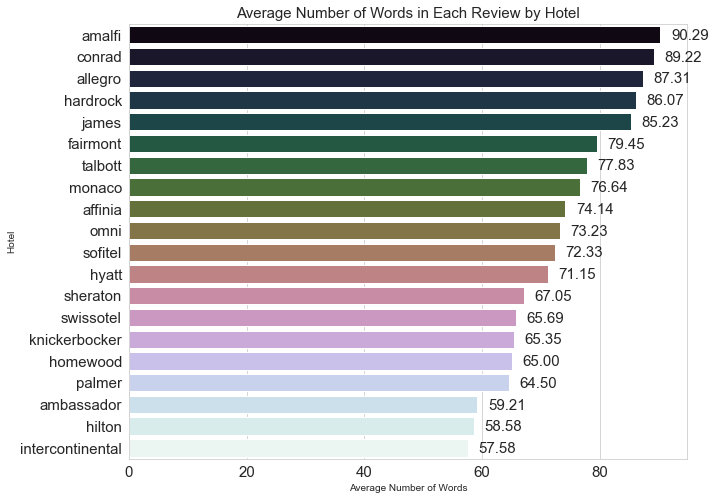

In [19]:
sns.set_style("whitegrid")
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)

g = sns.barplot(
    data=avg_words_review,
    y="Label", x="num_tokens", palette="cubehelix",ax=ax,
    order=avg_words_review.sort_values('num_tokens',ascending = False).Label
)
for p in g.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center',size=15)
g.set(xlabel='Average Number of Words', ylabel='Hotel')
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Average Number of Words in Each Review by Hotel", size=15)

The average number of words in each review is 73.04. In the above chart, it is shown the average number of words in each review by hotel. Amalfi hotel has the highest average number of words in each review 90.29, and Intercontinental hotel has the lowest average number of words in each review 57.58.

### Standard deviation of words in each review and per hotel

In [20]:
print("Standard deviation of words per review: ",np.std(review_lengths_in_tokens))

Standard deviation of words per review:  38.79217349684566


In [21]:
print("Standard deviation of words per review by hotel: ")
results = X_data_test['num_tokens'].groupby(X_data_test['Hotel']).std()
avg_sd_reviews=(results).to_frame()
avg_sd_reviews.rename(columns = {'num_tokens':'num_tokens_sd'}, inplace = True)
avg_sd_reviews['Label'] = list(avg_sd_reviews.index)
print(avg_sd_reviews.to_string(index=False))

Standard deviation of words per review by hotel: 
 num_tokens_sd             Label
     43.603512           affinia
     39.902766           allegro
     37.959251            amalfi
     26.388163        ambassador
     53.000062            conrad
     50.623472          fairmont
     41.259573          hardrock
     20.241534            hilton
     22.462667          homewood
     54.029076             hyatt
     44.256398  intercontinental
     33.650542             james
     32.860591     knickerbocker
     33.311137            monaco
     40.947095              omni
     29.130344            palmer
     32.234262          sheraton
     32.958054           sofitel
     33.875692         swissotel
     44.578497           talbott


Text(0.5, 1.0, 'Standard deviation of Words per Review by Hotel')

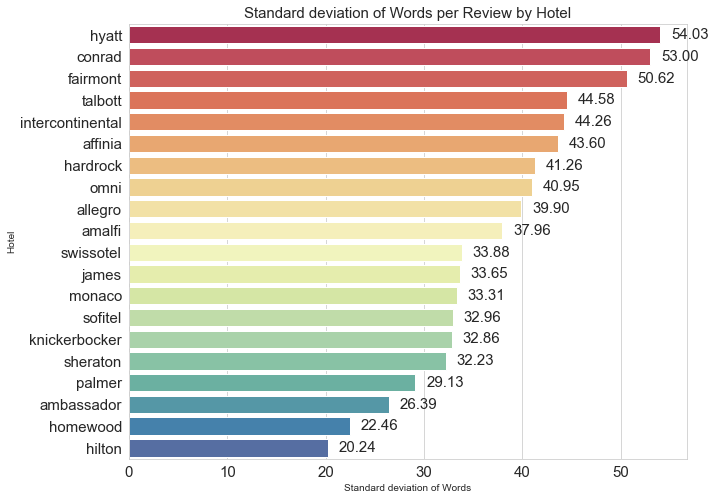

In [22]:
sns.set_style("whitegrid")
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)

g = sns.barplot(
    data=avg_sd_reviews,
    y="Label", x="num_tokens_sd", palette="Spectral",ax=ax,
    order=avg_sd_reviews.sort_values('num_tokens_sd',ascending = False).Label
)
for p in g.patches:
    width = p.get_width()
    plt.text(3+p.get_width(), p.get_y()+0.5*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center',size=15)
g.set(xlabel='Standard deviation of Words', ylabel='Hotel')
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Standard deviation of Words per Review by Hotel", size=15)

Standard deviation of words in each review is 38.79. 

In the above chart, it is shown the standard deviation of words in each review by hotel. Hyatt hotel has the highest standard deviation of words in each review 54.03, and Hilton hotel has the lowest standard deviation of words in each review 20.24. This indicates that number of words of review for Hilton are much clustered around the mean, number of words of review for Hyatt are much more spread out. 

Standard deviations of words in test data set are large since the sample size is small, there are only 320 records for 20 hotels, number of reviews for each hotel range from 7 to 26. As the sample size increasing, the standard deviation will decrease. 

### The total number of tokens corresponding to the top 20 most frequent words

In [23]:
top_20_sum = sum([pair[1] for pair in sorted_vocabulary[0:20]])
print("Total tokens represented by top 20 words:",top_20_sum)

Total tokens represented by top 20 words: 4371


In [24]:
words=[pair[0] for pair in sorted_vocabulary[0:20]]
counts=[pair[1] for pair in sorted_vocabulary[0:20]]

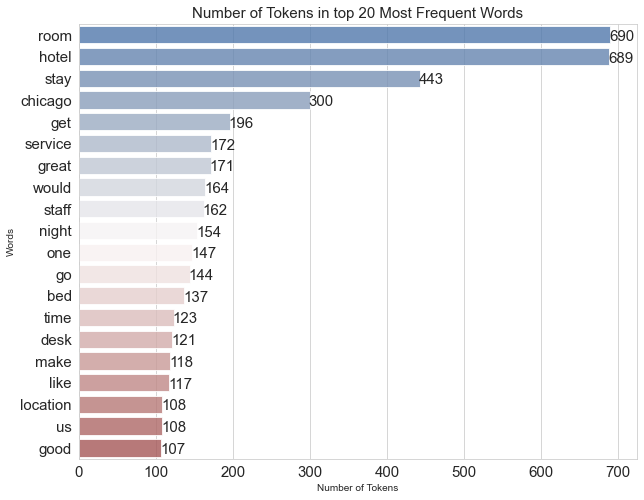

In [25]:
sns.set_style("whitegrid")
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)

g = sns.barplot(
    y=words, x=counts, palette="vlag",alpha=0.8,ax=ax)
for p in g.patches:
    width = p.get_width()
    plt.text(15+p.get_width(), p.get_y()+0.6*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center',size=15)
g.set(xlabel='Number of Tokens', ylabel='Words')
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Number of Tokens in top 20 Most Frequent Words", size=15)
sns.set(rc={'figure.figsize':(15,15)})

The total number of tokens corresponding to the top 20 most frequent words in the vocabulary is 4371. The above chart is shown the distribution of top 20 most frequent words. The most frequent word is "room". "room", "stay", "service", "staff", "desk" are very frequent words in reviews.

### The total number of tokens corresponding to the top 20 most frequent words by hotel

In [26]:
print("Total tokens for top 20 words by hotel:")
hotel=[]
top_sum=[]
for cur_hotel in hotel_vocabularies.keys():
    cur_vocab = hotel_vocabularies[cur_hotel]
    top_20_sum = sum([pair[1] for pair in cur_vocab[0:20]])
    print("{}: {}".format(cur_hotel, top_20_sum))
    hotel.append(cur_hotel)
    top_sum.append(top_20_sum)
df = pd.DataFrame({'Hotel':hotel, 'Number of tokens':top_sum})

Total tokens for top 20 words by hotel:
sofitel: 324
talbott: 195
james: 228
hardrock: 299
knickerbocker: 313
palmer: 213
conrad: 349
allegro: 238
homewood: 199
swissotel: 236
ambassador: 215
sheraton: 345
hilton: 165
monaco: 236
fairmont: 339
hyatt: 187
affinia: 319
intercontinental: 175
omni: 367
amalfi: 148


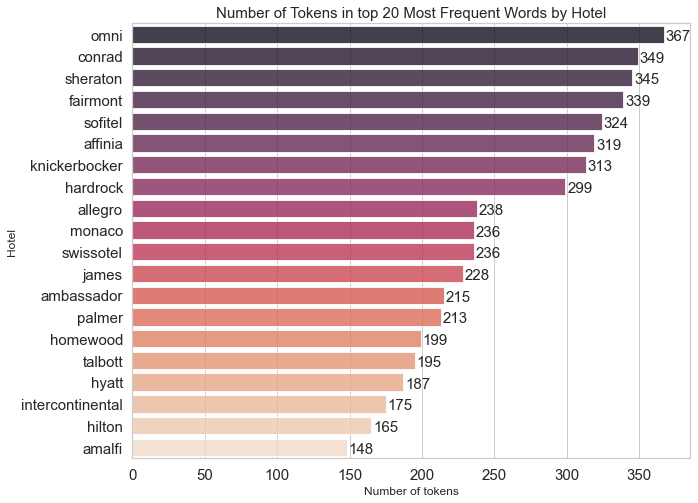

In [27]:
sns.set_style("whitegrid")
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)

g = sns.barplot(
    data=df,
    y="Hotel", x="Number of tokens", palette="rocket",alpha=0.8,ax=ax,
    order=df.sort_values('Number of tokens',ascending = False).Hotel)
for p in g.patches:
    width = p.get_width()
    plt.text(10+p.get_width(), p.get_y()+0.6*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center',size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Number of Tokens in top 20 Most Frequent Words by Hotel", size=15)
sns.set(rc={'figure.figsize':(10,7)})

The chart above is shown distribution of the number of tokens in top 20 most frequent words by hotel. Onmi hotel has the highest number of tokens in top 20 most frequent words. Amalfi hotel has the lowest number of tokens in top 20 most frequent words.

### Percentage of vocabulary

In [28]:
print("Percentage of vocabulary:", len(vocabulary)/X_data_test['num_tokens'].sum())
print("Tokens per vocabulary",X_data_test['num_tokens'].sum()/len(vocabulary))

Percentage of vocabulary: 0.149617079536217
Tokens per vocabulary 6.68372891049471


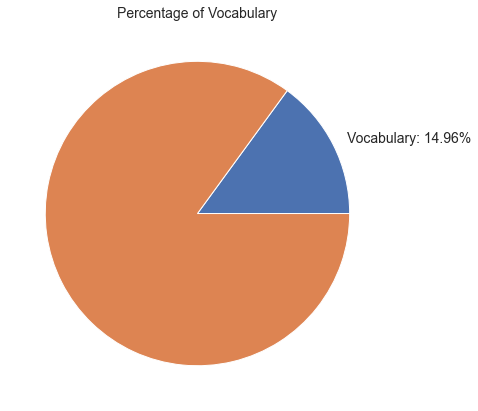

In [29]:
v=round(100*(len(vocabulary)/total_tokens),2)
name='Vocabulary: {}%'.format(v)
names=name,''
size=[len(vocabulary),total_tokens-len(vocabulary)]
 
# Create a circle for the center of the plot
plt.pie(size, labels=names,textprops={'fontsize': 14})
p=plt.gcf()
plt.title("Percentage of Vocabulary", size=14)
plt.show()

Overall, 14.96% of tokens are vocabularies. On average, each vocabulary repeats 6.7 times in the data set.

###  Percentage of vocabulary per hotel 

In [30]:
print("Percentage of vocabulary by hotel:")
hotel=[]
ratio=[]
for cur_hotel in hotel_vocabularies.keys():
    cur_vocab = hotel_vocabularies[cur_hotel]
    type_tok_ratio = round (100 * (len(cur_vocab)/ sum([pair[1] for pair in cur_vocab])),2)
    print("  {}: {}".format(cur_hotel,type_tok_ratio))
    hotel.append(cur_hotel)
    ratio.append(type_tok_ratio)
df_ratio = pd.DataFrame({'Hotel':hotel, 'Percentage of vocabulary':ratio})
df_ratio

Percentage of vocabulary by hotel:
  sofitel: 46.41
  talbott: 53.85
  james: 52.8
  hardrock: 48.41
  knickerbocker: 47.36
  palmer: 52.71
  conrad: 43.52
  allegro: 51.45
  homewood: 55.49
  swissotel: 49.86
  ambassador: 53.08
  sheraton: 44.03
  hilton: 60.88
  monaco: 53.31
  fairmont: 46.28
  hyatt: 55.24
  affinia: 47.15
  intercontinental: 56.44
  omni: 41.7
  amalfi: 59.65


,Hotel,Percentage of vocabulary
0,sofitel,46.41
1,talbott,53.85
2,james,52.80
3,hardrock,48.41
4,knickerbocker,47.36
5,palmer,52.71
6,conrad,43.52
7,allegro,51.45
8,homewood,55.49
9,swissotel,49.86


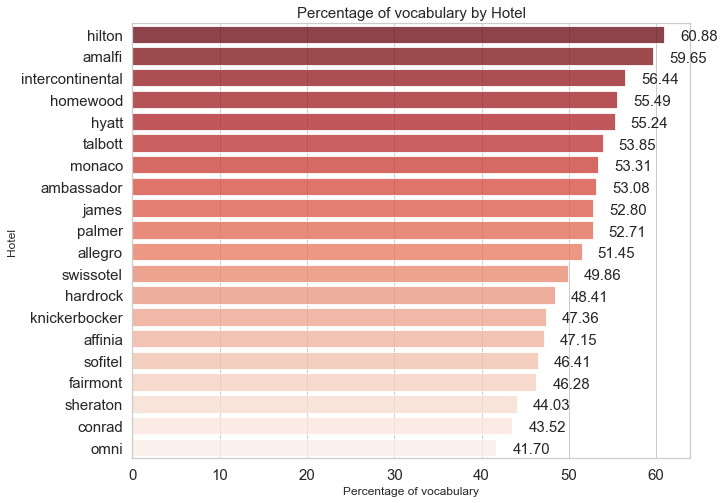

In [31]:
sns.set_style("whitegrid")
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)

g = sns.barplot(
    data=df_ratio,
    y="Hotel", x="Percentage of vocabulary", palette="Reds_r",alpha=0.8,ax=ax,
    order=df_ratio.sort_values('Percentage of vocabulary',ascending = False).Hotel)
for p in g.patches:
    width = p.get_width()
    plt.text(4+p.get_width(), p.get_y()+0.6*p.get_height(),
             '{:.2f}'.format(width),
             ha='center', va='center',size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title("Percentage of vocabulary by Hotel", size=15)
sns.set(rc={'figure.figsize':(10,7)})

The above charts are shown percentage of vocabulary in each hotel. Hilton hotel has the highest percentage of vocabulary 60.88, Omni hotel has the lowest percentage of vocabulary 41.70.

Percentages of vocabulary in 20 hotels are much higher than the overall percentages of vocabulary 14.96, one reason is that there are a lot of shared type (vocabulary) among 20 hotels, another reason is that the sample size of each hotel is small, as the sample size increasing, percentages of vocabulary by hotel will decrease.